In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [2]:
# My mac
data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
#data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
import geopandas as gpd

In [4]:
from django.contrib.gis import geos
from shapely.geometry import Point

In [5]:
data['geometry'] = data.apply(lambda z: Point(z.LON, z.LAT), axis=1)
new_data = gpd.GeoDataFrame(data)

## Let´s reproject to Alberts or something with distance

In [6]:
new_data.crs = {'init':'epsg:4326'}

### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [7]:
#new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

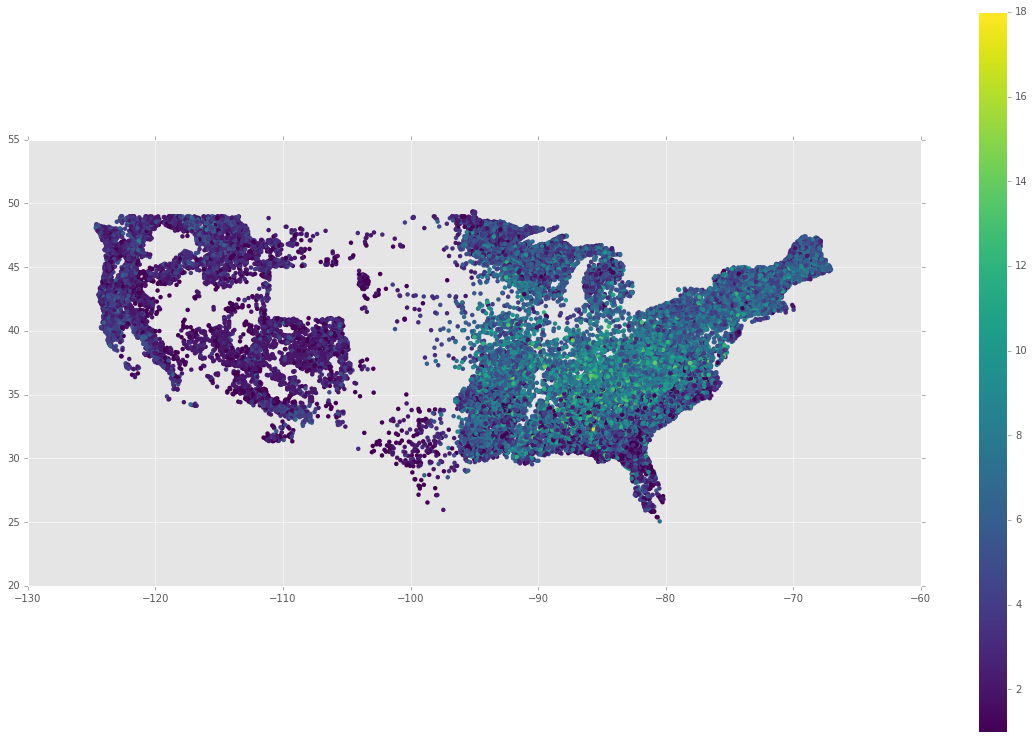

In [8]:
#fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
#plt.scatter(data.lon,data.lat,c=data.SppN,edgecolors='')
colormap = plt.cm.viridis
ax= new_data.plot(column='SppN',figsize=(16,10),cmap=colormap,edgecolors='') 
## To add colorbar from stack exchange use:
# add colorbar
fig = ax.get_figure()
# Left
l = 0.95
# Bottom
b = 0
# Width
w = 0.025
# Height
h = 1.0

miny = min(new_data.SppN)
maxy = max(new_data.SppN)
cax = fig.add_axes([l, b, w, h])
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=miny, vmax=maxy))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)




#fg = axs.get_figure()
#fig.add_axes(fig2)
#plt.colorbar()
#plt.title("Species Richness")


## The area is very big -> 35000 points. 
We need to make a subset of this


In [9]:
# COnsider the the following subregion
section = new_data[lambda x:  (x.LON > -90) & (x.LON < -80) & (x.LAT > 40) & (x.LAT < 50) ]

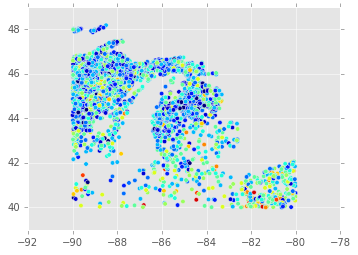

In [10]:
section.plot(column='SppN')

In [11]:
section.shape

(2842, 42)

In [12]:
section['newLon'] = section.apply(lambda c : c.geometry.x, axis=1)
section['newLat'] = section.apply(lambda c : c.geometry.y, axis=1)

/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Model Fitting Using a GLM 

The general model will have the form:
$$ Biomass(x,y) = \beta_1 AET + \beta_2 Age + Z(x,y) + \epsilon $$
Where:
$\beta_1$ and $\beta_2$ are model parameters, $Z(x,y)$ is the *Spatial Autocorrelation* process and $\epsilon \sim N(0,\sigma^2)$

In [13]:
##### OLD #######
len(data.lon)
#X = data[['AET','StandAge','lon','lat']]
X = data[['SppN','lon','lat']]
#X = data[['lon','lat']]
Y = data['plotBiomass']
#Y = data[['SppN']]
## First step in spatial autocorrelation
#Y = pd.DataFrame(np.zeros(len(Y)))
## Let´s take a small sample only for the spatial autocorrelation
import numpy as np
sample_size = 2000
randindx = np.random.randint(0,X.shape[0],sample_size)
nX = X.loc[randindx]
nY = Y.loc[randindx]


## For new section

In [14]:
X = section[['newLon','newLat']]
#X = data[['lon','lat']]
Y = section['SppN']
sample_size = Y.shape[0]

In [15]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )

In [16]:
model = gf.gpr.GPR(X.as_matrix(),Y.as_matrix().reshape(sample_size,1).astype(float),k)

In [17]:
model.likelihood.variance = 10
model.optimize()

      fun: 6104.8797298120953
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.68186719e-05,   8.59081051e-05,   3.86590442e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 33
   status: 0
  success: True
        x: array([ 87.91317332,  35.96685615,   4.04995082])

In [18]:
import numpy as np
Nn = 300
dsc = section
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [19]:
predicted_coordinates.shape

(90000, 2)

In [20]:
means,variances = model.predict_y(predicted_coordinates)

In [21]:
means.shape

(90000, 1)

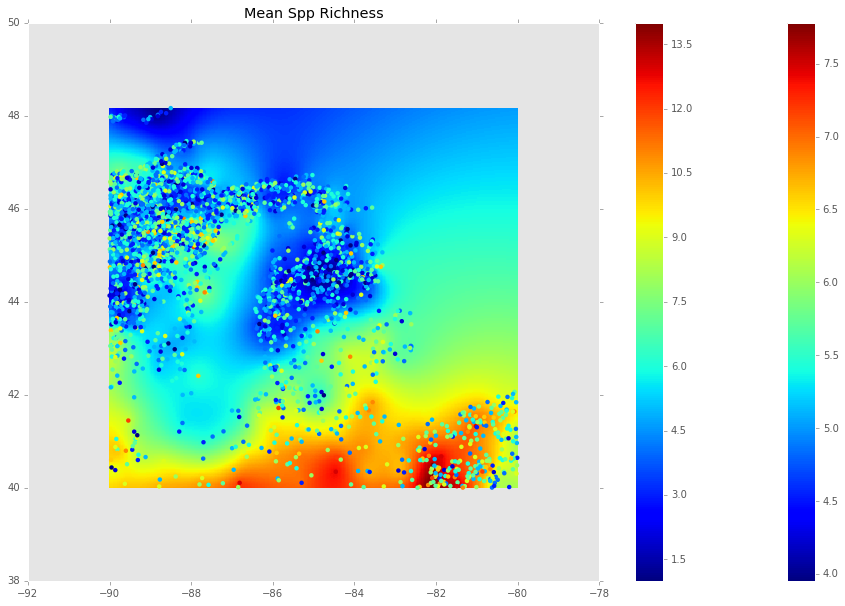

In [22]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.pcolormesh(Xx,Yy,means.reshape(Nn,Nn)) #,cmap=plt.cm.Greens)
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("Mean Spp Richness")
plt.colorbar()



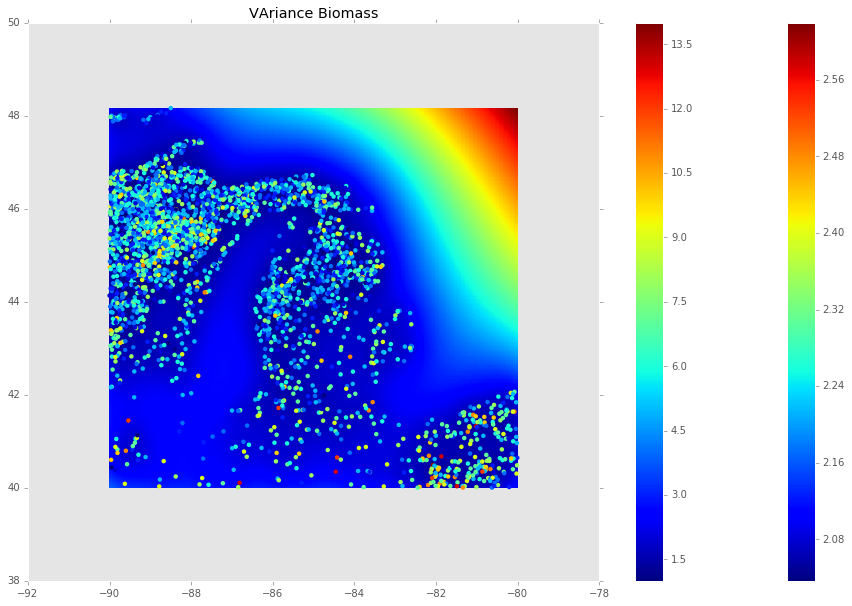

In [23]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
#plt.pcolor(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn))) #,cmap=plt.cm.Greens)
plt.pcolormesh(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn)))
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("VAriance Biomass")
plt.colorbar()

In [24]:
78000/12*20

130000

In [25]:
plt.pcolormesh?

# Let's bring some spatial data

In [26]:
from sketches.models import Country
Us = Country.objects.filter(name__contains='United States')[1]

In [27]:
from shapely.geometry import MultiPolygon
from shapely.wkt import loads

In [28]:
ppp = loads(Us.geom.wkt)

In [29]:
import cartopy.crs as ccrs

ImportError: No module named cartopy.crs

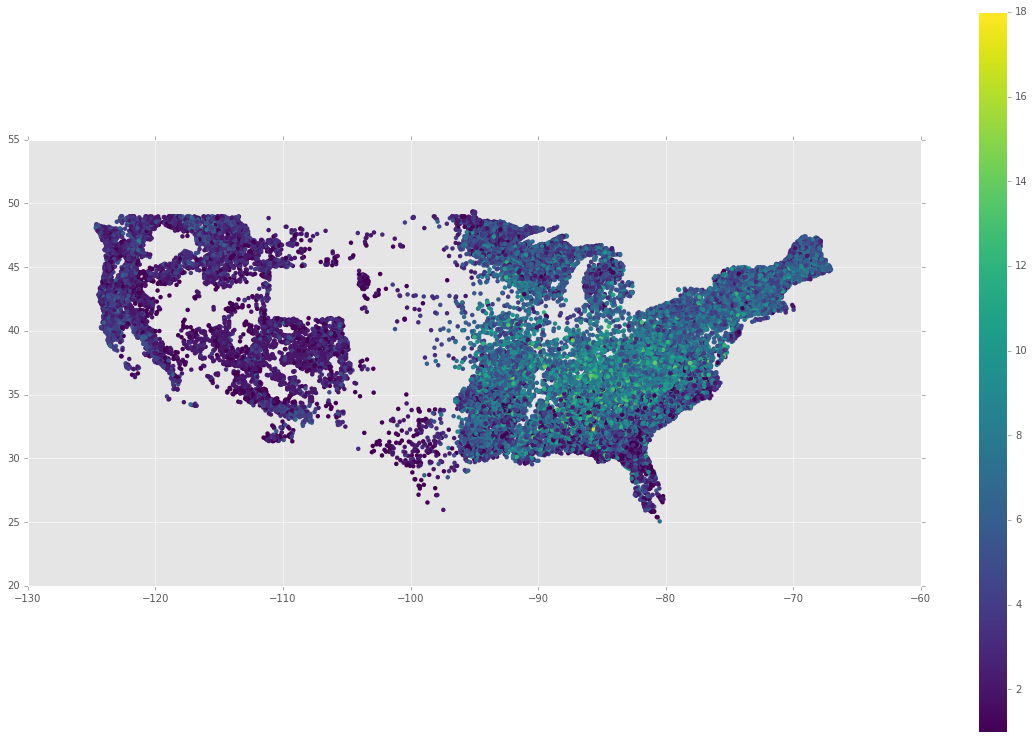

In [30]:
ax= new_data.plot(column='SppN',figsize=(16,10),cmap=colormap,edgecolors='') 
## To add colorbar from stack exchange use:
# add colorbar
fig = ax.get_figure()
# Left
l = 0.95
# Bottom
b = 0
# Width
w = 0.025
# Height
h = 1.0

miny = min(new_data.SppN)
maxy = max(new_data.SppN)
cax = fig.add_axes([l, b, w, h])
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=miny, vmax=maxy))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)






In [236]:
import cartopy

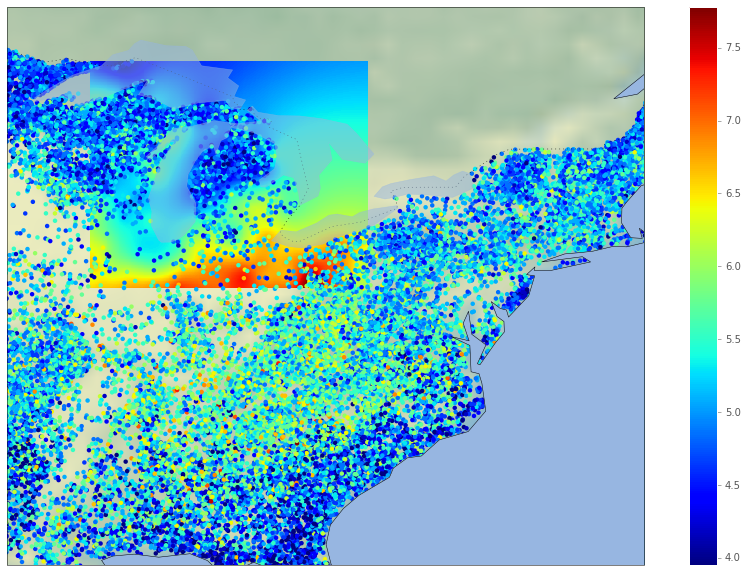

In [303]:
plt.figure(figsize=(16,10))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


ax.set_extent([-93, -70, 30, 50])
#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn),transform=proj )
ax.scatter(new_data.lon,new_data.lat,c=new_data.SppN,edgecolors='',transform=proj)
plt.colorbar(mm)



#(x.LON > -90) & (x.LON < -80) & (x.LAT > 40) & (x.LAT < 50)

# Now for all the data

In [ ]:
new_data['newLon'] = section.apply(lambda c : c.geometry.x, axis=1)
new_data['newLat'] = section.apply(lambda c : c.geometry.y, axis=1)


X = new_data[['newLon','newLat']]
#X = data[['lon','lat']]
Y = new_data['SppN']
sample_size = Y.shape[0]
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )
model = gf.gpr.GPR(X.as_matrix(),Y.as_matrix().reshape(sample_size,1).astype(float),k)
model.likelihood.variance = 10
%time model.optimize()
import numpy as np
Nn = 1000
dsc = new_data
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)

## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()


#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()
means,variances = model.predict_y(predicted_coordinates)
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.pcolormesh(Xx,Yy,means.reshape(Nn,Nn)) #,cmap=plt.cm.Greens)
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("Mean Spp Richness")
plt.colorbar()
